In [1]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Available electrodes - only frontal
ELECTRODES = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8']

# Setup - Model Architecture and Data functions

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=6, hidden_size1=128, hidden_size2=64, output_size=2500):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size1,
                            batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=hidden_size1,
                            hidden_size=hidden_size2,
                            batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size2, 256)
        self.fc2 = nn.Linear(256, output_size * input_size)  # output_size per electrode
        self.relu = nn.ReLU()
        
        self.input_size = input_size
        self.output_size = output_size
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # First LSTM layer
        lstm_out1, _ = self.lstm1(x)
        # Reshape for batch normalization
        lstm_out1 = lstm_out1.permute(0, 2, 1)
        bn_out1 = self.bn1(lstm_out1)
        bn_out1 = bn_out1.permute(0, 2, 1)
        
        # Second LSTM layer
        lstm_out2, _ = self.lstm2(bn_out1)
        # Take the last output
        lstm_out2 = lstm_out2[:, -1, :]
        bn_out2 = self.bn2(lstm_out2.unsqueeze(2)).squeeze(2)
        
        # Fully connected layers
        out = self.relu(self.fc1(bn_out2))
        out = self.fc2(out)
        
        # Reshape output to (batch_size, output_size, num_electrodes)
        out = out.view(batch_size, self.output_size, self.input_size)
        
        return out

class EEGDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.FloatTensor(inputs)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    best_val_loss = float('inf')
    total_train_loss = []
    total_val_loss = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        # Training loop
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        total_train_loss.append(avg_train_loss)
        total_val_loss.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    return total_train_loss, total_val_loss

def load_and_preprocess_data(start_idx, end_idx):
    print(f"Loading data for patients {start_idx-1000}-{end_idx-1000}...")
    path = [f"C:\\Users\\orben\\Downloads\\Data for ML project\\sub-{str(i)[1:]}\\eeg\\sub-{str(i)[1:]}_task-eyesclosed_eeg.set" for i in range(start_idx, end_idx + 1)]
    
    eeg_data = []
    for file_path in tqdm(path):
        # Load the EEG data
        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        # Select only frontal electrodes
        data = raw.get_data(picks=ELECTRODES)
        eeg_data.append(data)
    
    return eeg_data

def segment_data(data, window_size, predict_size, overlap=0.5):
    inputs = []
    labels = []

    for recording in data:
        # Initialize scaler for each recording
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Reshape to (time_points, channels) for scaling
        recording_reshaped = recording.T
        
        # Scale the data
        normalized = scaler.fit_transform(recording_reshaped)
        
        # Segment the data into overlapping windows
        for start in range(0, normalized.shape[0] - window_size - predict_size, int(window_size * (1 - overlap))):
            # Extract segments for all channels
            input_segment = normalized[start:start + window_size, :]
            label_segment = normalized[start + window_size:start + window_size + predict_size, :]
            inputs.append(input_segment)
            labels.append(label_segment)

    return np.array(inputs), np.array(labels)

In [ ]:
# Parameters
SEGMENT_LENGTH = 50  # Input length in seconds
PREDICTION_LENGTH = 5  # Prediction length in seconds
SAMPLING_RATE = 500  # EEG sampling rate (Hz)
WINDOW_SIZE = SEGMENT_LENGTH * SAMPLING_RATE  # Total input size
PREDICT_SIZE = PREDICTION_LENGTH * SAMPLING_RATE  # Total output size
OVERLAP = 0.5  # Overlap between windows
EPOCHS = 20  # Number of epochs
LAYER1 = 128  # Number of neurons in the first LSTM layer
LAYER2 = 64  # Number of neurons in the second LSTM layer
BATCH_SIZE = 32  # Batch size for training



# Data Prep

In [12]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.cuda.empty_cache()

# Define patient groups
PATIENT_GROUPS = {
    'AD': (1, 36),      # Alzheimer's Disease patients
    'Healthy': (37, 65), # Healthy patients
    'FTD': (66, 88)     # Frontotemporal Dementia patients
}
# Select which group to test on
TRAIN_GROUP = 'Healthy'  # Change this to train on different groups ('AD', 'Healthy', or 'FTD')
first, last = PATIENT_GROUPS[TRAIN_GROUP]

print(f"\nLoading {TRAIN_GROUP} patients data for training...")
eeg_data = load_and_preprocess_data(1000 + first, 1000 + last)
inputs, labels = segment_data(eeg_data, WINDOW_SIZE, PREDICT_SIZE, OVERLAP)

# Split into training and validation sets
print("\nSplitting data into training and validation sets...")
x_train, x_val, y_train, y_val = train_test_split(
    inputs, labels, test_size=0.2, random_state=42)

Using device: cuda

Loading Healthy patients data for training...
Loading data for patients 37-65...


100%|██████████| 29/29 [00:04<00:00,  5.93it/s]



Splitting data into training and validation sets...


In [13]:
# Create datasets and dataloaders
train_dataset = EEGDataset(x_train, y_train)
val_dataset = EEGDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print(f"\nData shapes:")
print(f"Training data: {x_train.shape}")
print(f"Validation data: {x_val.shape}")




Data shapes:
Training data: (744, 25000, 6)
Validation data: (186, 25000, 6)


# Model Build and Training

In [14]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=len(ELECTRODES), hidden_size1=LAYER1, hidden_size2=LAYER2, output_size=PREDICT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
# Train the model
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print(f"\nTraining the model on {TRAIN_GROUP} patients data...")
train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)


Training the model on Healthy patients data...


Epoch 1/20: 100%|██████████| 47/47 [03:46<00:00,  4.83s/it]


Epoch 1/20:
Training Loss: 0.0640
Validation Loss: 0.0509


Epoch 2/20: 100%|██████████| 47/47 [03:31<00:00,  4.49s/it]


Epoch 2/20:
Training Loss: 0.0169
Validation Loss: 0.0132


Epoch 3/20: 100%|██████████| 47/47 [03:41<00:00,  4.72s/it]


Epoch 3/20:
Training Loss: 0.0167
Validation Loss: 0.0143


Epoch 4/20: 100%|██████████| 47/47 [03:48<00:00,  4.86s/it]


Epoch 4/20:
Training Loss: 0.0138
Validation Loss: 0.0123


Epoch 5/20: 100%|██████████| 47/47 [03:37<00:00,  4.62s/it]


Epoch 5/20:
Training Loss: 0.0126
Validation Loss: 0.0141


Epoch 6/20: 100%|██████████| 47/47 [03:36<00:00,  4.61s/it]


Epoch 6/20:
Training Loss: 0.0117
Validation Loss: 0.0126


Epoch 7/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 7/20:
Training Loss: 0.0130
Validation Loss: 0.0125


Epoch 8/20: 100%|██████████| 47/47 [03:44<00:00,  4.78s/it]


Epoch 8/20:
Training Loss: 0.0127
Validation Loss: 0.0123


Epoch 9/20: 100%|██████████| 47/47 [03:45<00:00,  4.81s/it]


Epoch 9/20:
Training Loss: 0.0124
Validation Loss: 0.0108


Epoch 10/20: 100%|██████████| 47/47 [03:46<00:00,  4.81s/it]


Epoch 10/20:
Training Loss: 0.0108
Validation Loss: 0.0161


Epoch 11/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 11/20:
Training Loss: 0.0104
Validation Loss: 0.0097


Epoch 12/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 12/20:
Training Loss: 0.0104
Validation Loss: 0.0097


Epoch 13/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 13/20:
Training Loss: 0.0109
Validation Loss: 0.0135


Epoch 14/20: 100%|██████████| 47/47 [03:43<00:00,  4.77s/it]


Epoch 14/20:
Training Loss: 0.0123
Validation Loss: 0.0106


Epoch 15/20: 100%|██████████| 47/47 [03:43<00:00,  4.76s/it]


Epoch 15/20:
Training Loss: 0.0104
Validation Loss: 0.0147


Epoch 16/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 16/20:
Training Loss: 0.0112
Validation Loss: 0.0117


Epoch 17/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 17/20:
Training Loss: 0.0106
Validation Loss: 0.0100


Epoch 18/20: 100%|██████████| 47/47 [03:46<00:00,  4.81s/it]


Epoch 18/20:
Training Loss: 0.0092
Validation Loss: 0.0094


Epoch 19/20: 100%|██████████| 47/47 [03:44<00:00,  4.77s/it]


Epoch 19/20:
Training Loss: 0.0101
Validation Loss: 0.0139


Epoch 20/20: 100%|██████████| 47/47 [03:43<00:00,  4.75s/it]


Epoch 20/20:
Training Loss: 0.0090
Validation Loss: 0.0096


## Plot Training

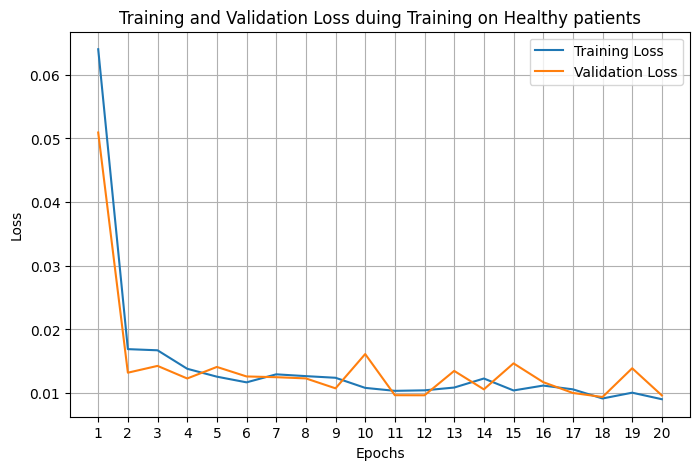

In [23]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1,EPOCHS+1), train_loss, label='Training Loss')
plt.plot(range(1,EPOCHS+1),val_loss, label='Validation Loss')
plt.title(f'Training and Validation Loss duing Training on {TRAIN_GROUP} patients')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1,EPOCHS+1))
plt.legend()
plt.grid()


## Save Model

In [9]:
# Create Models directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

# Save the final model
model_path = f'Models/{SEGMENT_LENGTH}-{PREDICTION_LENGTH}_{TRAIN_GROUP}_patients_model({LAYER1},{LAYER2}){EPOCHS}epochsOverlap{OVERLAP}frontal-electrodes(2).pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel saved to {model_path}")


Model saved to Models/50-5_FTD_patients_model(128,64)20epochsOverlap0.5frontal-electrodes(2).pth
